In [1]:
import sys, random
import matplotlib.pyplot as plt
from contextualbandits import online as cb
from copy import deepcopy as clone
import numpy as np
import pandas as pd
# Only classifiers that have partial_fit are relevant
# See: https://scikit-learn.org/0.15/modules/scaling_strategies.html
from sklearn.linear_model import SGDClassifier
%matplotlib inline

In [2]:
prices_dict = {
     ('US', 'Android'):7,
     ('GB', 'Android'):5,
     ('DE', 'Android'):4,
     ('US', 'iOS'):9,
     ('GB', 'iOS'):6,
     ('DE', 'iOS'):5,
              }


def synthesize_data(prices_dict, n=10, epsilon=0.01, drop=[]):
    """This function generates data 
    Parameters:
        prices_dict: dictionary holds relevant context and historical prices - geo + deviceOs
        n: dataset size
        epsilon: noise for price decision
    Returns:
        df: Pandas DataFrame
    """
    data = []
    for i in range(n):
        geo = random.choice(["US","US","US","US","US", "GB","GB", "DE"])
        deviceOs = random.choice(['iOS', 'Android'])
        bid = random.randint(1,1000)
        has_won = (bid/100) >= prices_dict[(geo, deviceOs)] + 2 * epsilon * (random.random() - 0.5)
        data.append((geo, deviceOs, bid, has_won))
    df = pd.DataFrame(data, columns = ['geo', 'deviceOs', 'bid', 'hasWon'])
    if drop:
        df.drop(drop, inplace=True, axis=1)
    return pd.get_dummies(df)


df = synthesize_data(prices_dict, n=500)
df

,bid,hasWon,geo_DE,geo_GB,geo_US,deviceOs_Android,deviceOs_iOS
0,29,False,0,1,0,1,0
1,542,True,1,0,0,0,1
2,2,False,0,1,0,1,0
3,421,False,0,1,0,0,1
4,399,False,0,0,1,1,0
...,...,...,...,...,...,...,...
495,607,False,0,0,1,1,0
496,324,False,0,0,1,1,0
497,697,True,0,1,0,1,0
498,248,False,0,0,1,1,0


In [3]:
X = df.drop(["hasWon", "bid"], axis=1)
r = df['hasWon']
a = df["bid"]

# Read data & preprocess

# Contextual bandits

In [4]:
class SGDClassifierWithNormalization(SGDClassifier):
    def __init__(self, loss, desired_win_rate, eps=0.0001, normalizing_factor=1e-3, **kwargs):
        super().__init__(loss, **kwargs)
        self.desired_win_rate = desired_win_rate
        self.eps = eps
        self.normalizing_factor=normalizing_factor
        
    def predict_proba(self, X):
        probs = super().predict_proba(X)[:, 1] # predict proba as of any predict_proba model classifier
        y = 1 / np.abs(probs - self.desired_win_rate + self.eps) # Numerical stability
        y = 1 - np.exp(-y*self.normalizing_factor) # Normalize
        
        return np.vstack((1-y, y)).T

In [5]:
n_arms = 1000 # number of bins
bids = np.arange(0,1001)
base_model = SGDClassifierWithNormalization(desired_win_rate=0.9, loss='log')
# SeperateClassifiers, there are many strategies for sampling
logreg_sg = cb.SeparateClassifiers(clone(base_model), n_arms, batch_train=True)

In [6]:
def multiple_update(train_X,train_a,train_r):
    """
    If we won with a $5 bid, update also $6, $7 etc... with a 'win' rewards
    If we lost with a $5 bid, update also $4, $3 etc... with a 'lose' rewards
    """
    temp_df = pd.concat([train_X,train_a,train_r], axis=1)
    temp_df["arms"] = temp_df.apply(lambda row: [a for a in bids if a>=row["bid"]] if row["hasWon"] else
                          [a for a in bids if a<=row["bid"]],axis=1)
    temp_df = temp_df.drop("bid", axis=1).explode("arms")
    train_X = temp_df.drop(["hasWon","arms"],axis=1)
    train_r = temp_df["hasWon"]
    train_a = temp_df["arms"]
    return train_X,train_a,train_r

def simulate(model, X, a , r,chunk = 10):
    X,a,r=map(clone,[X,a,r]) # copy the existing data so we won't change it
    
    train_X, train_a, train_r = X.iloc[:chunk,:], a[:chunk], r[:chunk]
    # split the data into train
    # Get chunk data points for first input
    X, a, r = X.iloc[chunk:,:], a[chunk:], r[chunk:]
    test_X, test_a, test_r = X.iloc[:chunk,:], a[:chunk], r[:chunk]
    regrets = []
    #TODO: Add initial train
    model.partial_fit(train_X,train_a,train_r)
    while len(X)>chunk:
        train_X,train_a,train_r = multiple_update(train_X,train_a,train_r)
        model.partial_fit(train_X,train_a,train_r)
        pred_bids = model.predict(test_X)
        assert chunk==len(test_a) and chunk==len(pred_bids)
        regret = np.mean([np.abs(b-y) for b,y in zip(pred_bids,test_a.values)])
        regrets.append(regret)
        train_X, train_a, train_r    = X.iloc[:chunk,:], a[:chunk], r[:chunk]
        X, a, r = X.iloc[chunk:,:], a[chunk:], r[chunk:]
        test_X, test_a, test_r = X.iloc[:chunk,:], a[:chunk], r[:chunk]
            
    return regrets

# plot

Text(0.5, 0, 'iterations')

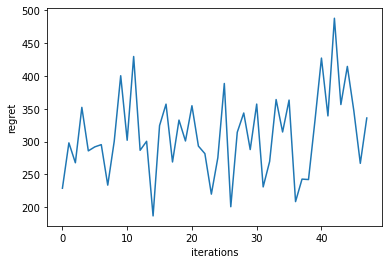

In [7]:
regret = simulate(logreg_sg, X, a, r)
plt.plot(np.arange(len(regret)), regret)
plt.ylabel("regret")
plt.xlabel("iterations")

Text(0.5, 0, 'iterations')

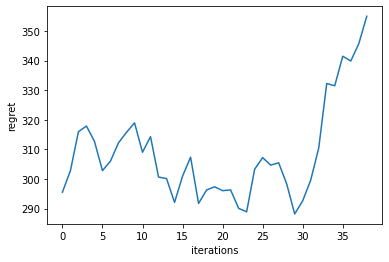

In [8]:
window_size=10
regret_smooth=np.convolve(regret,np.ones(window_size), 'valid')/window_size
plt.plot(np.arange(len(regret_smooth)), regret_smooth)
plt.ylabel("regret")
plt.xlabel("iterations")
# plt.ylim((0,0.3))

# Context-wise analysis

In [9]:
print(X.columns)
pred = logreg_sg.predict(np.array([
    [0,0,1,1,0], # US, Android
    [0,1,0,1,0], # GB, Android
    [1,0,0,1,0], # DE, Android
    [0,0,1,0,1], # US, IOS
    [0,1,0,0,1], # GB, IOS
    [1,0,0,0,1], # DE, IOS
]), output_score=True)
pred["bid"] = [bids[y] for y in pred['choice']]
pred

Index(['geo_DE', 'geo_GB', 'geo_US', 'deviceOs_Android', 'deviceOs_iOS'], dtype='object')


{'choice': array([719, 572, 420, 896, 594, 504]),
 'score': array([[0.01084347],
        [0.05179493],
        [0.01965117],
        [0.03271964],
        [0.01110906],
        [0.06428265]]),
 'bid': [719, 572, 420, 896, 594, 504]}

In [10]:
df_summary = \
pd.DataFrame([(p[0][0], p[0][1], p[1], c/100) for p,c in zip(prices_dict.items(), pred["choice"])],
            columns=["geo", "deviceOs", "actual", "bid"])
df_summary

,geo,deviceOs,actual,bid
0,US,Android,7,7.19
1,GB,Android,5,5.72
2,DE,Android,4,4.20
3,US,iOS,9,8.96
4,GB,iOS,6,5.94
5,DE,iOS,5,5.04


In [11]:
average_regret = (df_summary["actual"]-df_summary["bid"]).abs().sum()/len(pred["choice"])
average_regret

0.20833333333333318

# Smaller context
## Only Device Os

In [12]:
df = synthesize_data(prices_dict, n=500, drop='geo')
X = df.drop(["hasWon", "bid"], axis=1)
r = df['hasWon']
a = df["bid"]
one_feature_model = cb.SeparateClassifiers(clone(base_model), n_arms, batch_train=True)
simulate(one_feature_model, X, a, r)
print(X.columns)

Index(['deviceOs_Android', 'deviceOs_iOS'], dtype='object')


In [13]:
pred_bids = one_feature_model.predict(np.eye(X.shape[1]))
one_feature_bid = dict(zip(X.columns, pred_bids))
one_feature_bid

{'deviceOs_Android': 860, 'deviceOs_iOS': 889}

In [14]:
df_summary.groupby("deviceOs")["actual"].mean()

deviceOs
Android    5.333333
iOS        6.666667
Name: actual, dtype: float64

## Only Device Geo

In [15]:
df = synthesize_data(prices_dict, n=500, drop='deviceOs')
X = df.drop(["hasWon", "bid"], axis=1)
r = df['hasWon']
a = df["bid"]
one_feature_model = cb.SeparateClassifiers(clone(base_model), n_arms, batch_train=True)
simulate(one_feature_model, X, a, r)
print(X.columns)

Index(['geo_DE', 'geo_GB', 'geo_US'], dtype='object')


In [16]:
pred_bids = one_feature_model.predict(np.eye(X.shape[1]))
one_feature_bid = dict(zip(X.columns, pred_bids))
one_feature_bid

{'geo_DE': 471, 'geo_GB': 908, 'geo_US': 873}

In [17]:
df_summary.groupby("geo")["actual"].mean()

geo
DE    4.5
GB    5.5
US    8.0
Name: actual, dtype: float64